# Augmentations

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A

from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F

import config
import dataset
import engine
import models

In [4]:
df = pd.read_csv(config.TRAIN_CSV)

In [5]:
images = df[config.PIXEL_COLS].values.reshape(-1, 28, 28)

In [6]:
mean = np.mean(images / 255.0)
std = np.std(images / 255.0)
mean, std

(0.14825066447366889, 0.25799247475481873)

In [7]:
augs = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.9),
        A.OneOf(
            [
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                A.GridDistortion(),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
            ],
            p = 0.5
        ),
        A.CoarseDropout(max_holes=4, max_height=4, max_width=4, p=0.25),
        A.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True),
    ]
)

In [8]:
idx = 5
image = images[idx]
image = image.astype(np.uint8)

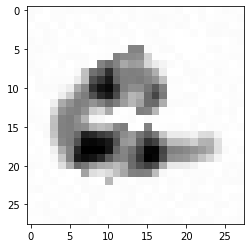

In [9]:
plt.imshow(image, cmap=plt.cm.binary);

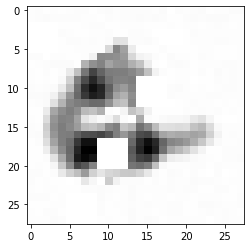

In [10]:
augmented = augs(image=image)
aug_image = augmented["image"]
plt.imshow(aug_image, cmap=plt.cm.binary);

## Train

In [11]:
device = torch.device(config.DEVICE)

In [12]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, stratify=df.digit)

train_dataset = dataset.EMNISTDataset(df_train, augs=augs)
valid_dataset = dataset.EMNISTDataset(df_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)    
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.TEST_BATCH_SIZE)

TypeError: __init__() missing 1 required positional argument: 'list_IDs'

In [13]:
model = models.SpinalVGG()
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', verbose=True, patience=10, factor=0.5
)

for epoch in range(config.EPOCHS):
    engine.train(train_loader, model, optimizer, device)
    predictions, targets = engine.evaluate(valid_loader, model, device)

    predictions = np.array(predictions)
    predictions = np.argmax(predictions, axis=1)
    accuracy = metrics.accuracy_score(targets, predictions)
    
    scheduler.step(accuracy)
    
    print(f"Epoch: {epoch}, Accuracy={accuracy}")

NameError: name 'train_loader' is not defined

In [29]:
torch.save(model.state_dict(), "../models/augs.pt")

## Inference

In [31]:
# model = models.Model()
model = models.SpinalVGG()
model.load_state_dict(torch.load("../models/augs.pt"))
model.to(device)

<All keys matched successfully>

In [19]:
df_test = pd.read_csv(config.TEST_CSV)
test_dataset = dataset.EMNISTTestDataset(df_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE)

In [49]:
predictions = engine.infer(test_loader, model, device)
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)

In [50]:
submission = pd.DataFrame({"id": df_test.id, "digit": predictions})
submission.to_csv("../output/augs.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
